# Knihovna Scikit-learn, přehled užitečných funkcí

V předešlé hodině jsme se vyhýbali programování, jak jen se to dalo. Teď už si ale chceš také sama vše vyzkoušet.
Abys mohla úlohu rozmyšlenou v domácím úkolu naprogramovat, projdeme si nejdůležitější funkce, které budeš potřebovat. Použijeme jednoduchá data [salaries.csv](static/salaries.csv)

Především budeme používat knihovnu [Scikit-learn](https://scikit-learn.org) a samozrejmě také pandas. 
Potřebné věci projdeme na příkladu. 

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

## Načtení a příprava dat 

<table> 
    <tr><td>
        
☑ výběr vstupních proměnných a výstupu

☑ rozdělení na trénovací a testovací data 
        
☑ chybějící hodnoty 

☑ kategorické hodnoty 

☑ přeškálování / normování hodnot  
 </td></tr>
</table> 

Na začátku vždy bude potřeba připravit data. Čištění dat a použití knihovny pandas už bys měla ovládat, 
zaměříme se jen na věci, které jsou specifické pro strojové učení.

Načíst data tedy umíš.

In [2]:
df_salary = pd.read_csv("static/salaries.csv", index_col=0)
df_salary.sample(10)

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
66,AssocProf,B,9,8,Male,100522
115,Prof,A,12,0,Female,105000
17,Prof,B,19,20,Male,101000
142,AssocProf,A,15,10,Male,81500
157,AssocProf,B,12,18,Male,113341
127,Prof,A,28,26,Male,155500
141,AssocProf,A,14,8,Male,100102
31,Prof,B,20,4,Male,132261
19,Prof,A,37,23,Male,124750
168,Prof,B,18,19,Male,130664


Pro přehlednost si data přeložme do češtiny.

In [3]:
df_salary = (
    df_salary
    .rename(columns={"discipline": "disciplina",
             "yrs.since.phd": "delka_praxe",
             "yrs.service": "delka_zamestnani",
             "sex": "pohlavi",
             "salary": "plat"})
    .replace({"Male": "muž",
              "Female": "žena",
              "Prof": "profesor",
              "AssocProf": "docent",
              "AsstProf": "asistent"})
)
df_salary

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi,plat
1,profesor,B,19,18,muž,139750
2,profesor,B,20,16,muž,173200
3,asistent,B,4,3,muž,79750
4,profesor,B,45,39,muž,115000
5,profesor,B,40,41,muž,141500
...,...,...,...,...,...,...
194,docent,B,19,19,muž,86250
195,docent,B,48,53,muž,90000
196,docent,B,9,7,muž,113600
197,asistent,B,4,4,muž,92700


## Vytvoření trénovací a testovací množiny

Pro predikci použijeme jako příznaky `rank`, `disciplina`, `delka_praxe`, `delka_zamestnani` a `pohlavi`, 
predikovat budeme hodnotu `plat`.  

V teorii strojového učení se vstupy modelu (příznaky, vstupní proměnné) typicky označují písmenem `X` a výstupy písmenem `y`. Řada programátorů toto používá i k označování proměnných v kódu. 
`X` představuje *matici* (neboli tabulku), kde každý řádek odpovídá jednomu datovému vzorku a každý sloupec jednomu příznaku (vstupní proměnné). `y` je vektor, neboli jeden sloupec s odezvou. 

(Na vyzobnutí odezvy se může hodit metoda [pop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pop.html). Její nevýhodou je ale nemožnost opakovaně spouštět buňku.)

In [4]:
y = df_salary["plat"]
X = df_salary.drop(columns=["plat"])

print(X.columns)
print(y.name)

Index(['rank', 'disciplina', 'delka_praxe', 'delka_zamestnani', 'pohlavi'], dtype='object')
plat


In [5]:
X.head()

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi
1,profesor,B,19,18,muž
2,profesor,B,20,16,muž
3,asistent,B,4,3,muž
4,profesor,B,45,39,muž
5,profesor,B,40,41,muž


In [6]:
y.head()

1    139750
2    173200
3     79750
4    115000
5    141500
Name: plat, dtype: int64

Zbývá data rozdělit na trénovací a testovací, to je třeba udělat co nejdříve, abychom při různých konverzích dat používali jen informace z trénovací množiny a testovací množina byla opravdu jen k evaluaci. K tomu slouží metoda [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split). 
Data nám rozdělí náhodně na trénovací a testovací sadu. Velikost testovací množiny můžeme specifikovat parametrem `test_size`, jeho defaultní hodnota je `0.25`, t. j. 25%.

In [7]:
from sklearn.model_selection import train_test_split 

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Kódování vstupů



Pro učení potřebujeme všechny hondoty převést na čísla (`float`). Pokud by data obsahovala chybějící
hodnoty, nejjednodušší řešení je takové řádky zahodit. (Bonus: pokud bys měla data s větším množstvím
chybějících hodnot, podívej se na možnosti [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute))

Dále je důležité vypořádat se s kategorickými hodnotami. Sloupce obsahující hodnoty typu Boolean nebo dvě hodnoty (např. muž/žena), lze snadno převést na hodnoty $[0,1]$. 

Pro kategorické proměnné s více možnostmi použijeme tzv. *onehot encoding*. 

Např. sloupec `rank` obsahuje hodnoty `profesor`, `docent` a `asistent`. K zakódování pomocí onehot encoding potřebujeme tři sloupce: 

Původní hodnota | Kód 
--- | --- 
profesor      | 1 0 0
docent  | 0 1 0 
asistent | 0 0 1  


Knihovna Scikitlearn nabízí [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). 

Při práci s pandas se může hodit i metoda [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). (Pozn. *dummies* proto, že nám přibudou pomocné proměnné (sloupce), které se označují jako *dummy variables*.) Ale pozor, pokud budeme později potřebovat stejným způsobem zakódovat další data, musí obsahovat stejné kategorie.

In [8]:
pd.get_dummies(X_train_raw).head()

,delka_praxe,delka_zamestnani,rank_asistent,rank_docent,rank_profesor,disciplina_A,disciplina_B,pohlavi_muž,pohlavi_žena
165,1,0,True,False,False,False,True,True,False
197,4,4,True,False,False,False,True,True,False
78,26,19,False,False,True,False,True,True,False
64,11,11,False,True,False,False,True,False,True
166,21,8,False,False,True,False,True,True,False


Naše data zakódujeme pomocí **OneHotEncoder** z knihovny Scikit-learn. 

OneHotEncoder si představ jako krabičku, která má vstupy a výstupy (podobně jako model strojového učení), a vstupy nějak transformuje na výstupy. Každá takováto krabička, která slouží pro přípravu (transformaci) dat, má metody:
+ fit
+ transform
+ fit_transform

Metoda `fit` slouží k inicializaci krabičky, nastavení na daná data. Metoda `transform` pak je samotný běh krabičky, provádí transformaci dat. Metoda `fit_transform` na daných datech krabičku inicializuje a poté data i transformuje.

Rozdělme si sloupečky (vstupní proměnné) podle datových typů.

In [9]:
categorical_columns = ["rank", "disciplina"] 
numerical_columns = ["delka_praxe", "delka_zamestnani"]
boolean_columns = ["pohlavi"]

Kategorické proměnné zakódujme pomocí one-hot kódování.

In [10]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(X_train_raw[categorical_columns])
# zeptejme se encodéru na jména nových proměnných (sloupečků)
column_names = encoder.get_feature_names_out()

In [11]:
column_names

array(['rank_asistent', 'rank_docent', 'rank_profesor', 'disciplina_A',
       'disciplina_B'], dtype=object)

In [12]:
encoder.transform(X_train_raw[categorical_columns])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 276 stored elements and shape (138, 5)>

Metoda `transform` nám vrátila objekt s řídkou maticí, která se hodí pro data zakódovaná pomocí one-hot kódování. My chceme data i přehledně vidět, proto zde použijeme parametr `sparse_output` a řídký výstup vypneme.

In [13]:
encoder1 = OneHotEncoder(sparse_output=False)
encoder1.fit(X_train_raw[categorical_columns])
encoder1.transform(X_train_raw[categorical_columns])

array([[1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0.

Umíme tedy vytvořit krabičku, která transformuje data. Zatím jsme jí dávali vybrané sloupce, nyní si pojďme ukázat, jak několik takových krabiček (každou pro jeden typ vstupů) poskládat dohromady do jedné velké krabičky, která umí transformovat celá data (všechny sloupce).

Začneme vytvořením krabičky, která kategorické sloupce zakóduje pomocí one-hot kódování a všechny ostatní nechá v původním stavu.

In [15]:
from sklearn.compose import make_column_transformer

In [16]:
transformer = make_column_transformer(
    # parameter handle_unkown ignore říká, že pokud při transformaci narazíme na neznámou hodnotu,
    # transformace neskončí chybou, ale hodnota se zakóduje pomocí samých 0 
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"),categorical_columns),
    remainder="passthrough"
)

In [17]:
transformer.fit(X_train_raw)
pd.DataFrame(transformer.transform(X_train_raw))

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,1.0,1,0,muž
1,1.0,0.0,0.0,0.0,1.0,4,4,muž
2,0.0,0.0,1.0,0.0,1.0,26,19,muž
3,0.0,1.0,0.0,0.0,1.0,11,11,žena
4,0.0,0.0,1.0,0.0,1.0,21,8,muž
...,...,...,...,...,...,...,...,...
133,0.0,0.0,1.0,0.0,1.0,28,36,muž
134,0.0,0.0,1.0,0.0,1.0,25,18,muž
135,1.0,0.0,0.0,0.0,1.0,3,3,žena
136,0.0,0.0,1.0,0.0,1.0,25,25,žena


In [18]:
transformer.get_feature_names_out()

array(['onehotencoder__rank_asistent', 'onehotencoder__rank_docent',
       'onehotencoder__rank_profesor', 'onehotencoder__disciplina_A',
       'onehotencoder__disciplina_B', 'remainder__delka_praxe',
       'remainder__delka_zamestnani', 'remainder__pohlavi'], dtype=object)

Teď zbývá zakódovat sloupeček pohlaví, který nabývá dvou hodnot. Samozřejmě můžeme použít i one-hot encoding, ale chceme si ukázat i jiné kódování. Nabízí se použití [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html), který zakóduje hodnoty jako čísla 0 až N-1, kde N je počet tříd. Přidejme tento kodér do našeho velkého transformátoru.

In [19]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), categorical_columns),
    (OrdinalEncoder(), boolean_columns),
    remainder="passthrough"
)

In [21]:
X_train_transformed = transformer.fit_transform(X_train_raw)
X_test_transformed = transformer.transform(X_test_raw)

In [22]:
column_names = transformer.get_feature_names_out()
pd.DataFrame(X_test_transformed, columns=column_names).head(10)

,onehotencoder__rank_asistent,onehotencoder__rank_docent,onehotencoder__rank_profesor,onehotencoder__disciplina_A,onehotencoder__disciplina_B,ordinalencoder__pohlavi,remainder__delka_praxe,remainder__delka_zamestnani
0,0.0,1.0,0.0,1.0,0.0,0.0,19.0,16.0
1,0.0,0.0,1.0,1.0,0.0,0.0,35.0,23.0
2,0.0,0.0,1.0,0.0,1.0,0.0,17.0,3.0
3,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,8.0,8.0
5,1.0,0.0,0.0,0.0,1.0,0.0,5.0,5.0
6,0.0,1.0,0.0,0.0,1.0,0.0,12.0,8.0
7,0.0,0.0,1.0,1.0,0.0,0.0,56.0,57.0
8,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0
9,0.0,0.0,1.0,0.0,1.0,0.0,37.0,37.0


In [23]:
transformer

,transformers,"[('onehotencoder', ...), ('ordinalencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


## Škálování

Přeškálování není vždy nutné, ale některým modelům to může pomoci. Řiďte se tedy pravidlem, že rozhodně neuškodí.
Využijeme [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

StandardScaler nám hodnoty přeškáluje, aby zhruba odpovídaly normálnímu rozdělení. Některé algoritmy (na učení) to předpokládají. Pokud bychom neškálovali, mohlo by se stát, že příznak (sloupeček), která má výrazně větší rozptyl než ostatní, je brán jako významnější. 

Nejprve si ukažme jednoduchý příklad. Vygenerujeme si dva sloupečky náhodných bodů, každý jiným způsobem. 

In [24]:
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
import seaborn as sns 

# vygeneruje 100 náhodných bodů
example = pd.DataFrame({"a": 100+np.random.randn(100), "b": 100*np.random.randn(100)})
example.head(20)

,a,b
0,100.888984,-260.878801
1,100.496064,-65.508528
2,100.055572,59.374218
3,100.060233,121.281507
4,98.560538,20.311355
5,99.616512,4.957273
6,100.886202,161.057846
7,99.766297,127.399339
8,100.044351,-86.858194
9,98.823873,11.641098


Podívejme se, jak sloupečky vypadají. Ve sloupci `a` máme hodnoty s malým rozptylem kolem 100 a ve sloupci `b` čísla s velkým rozptylem a průměrem v nule.

In [25]:
example.describe()

,a,b
count,100.000000,100.000000
mean,99.914380,-1.182795
std,0.967421,107.772840
min,97.540807,-260.878801
25%,99.252158,-75.710666
50%,99.846426,5.370076
75%,100.740273,66.216316
max,101.860778,217.284230


Data nyní přeškálujeme pomocí `StandardScaler` a podíváme se, jak vypadají původní a přeškálovaná data.

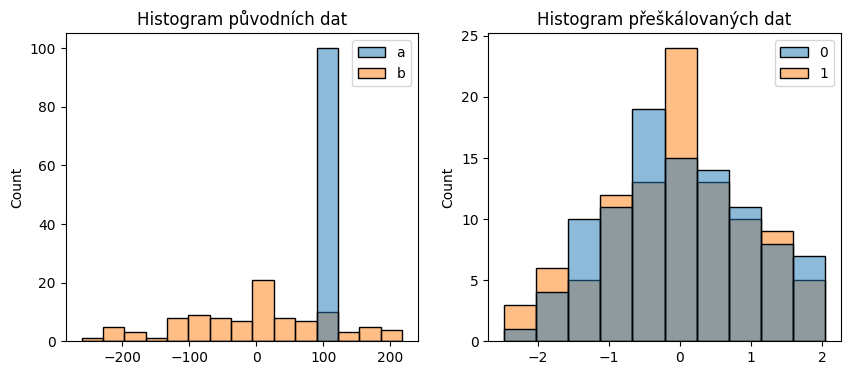

In [26]:
example_scaler = StandardScaler()
transformed_example = example_scaler.fit_transform(example)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
ax1.set_title("Histogram původních dat")
sns.histplot(example, ax=ax1)
ax2.set_title("Histogram přeškálovaných dat")
sns.histplot(transformed_example, ax=ax2);

In [27]:
pd.DataFrame(transformed_example).describe()

,0,1
count,1.000000e+02,1.000000e+02
mean,8.699708e-15,5.551115e-18
std,1.005038e+00,1.005038e+00
min,-2.465865e+00,-2.421800e+00
25%,-6.879710e-01,-6.950112e-01
50%,-7.059610e-02,6.110893e-02
75%,8.580067e-01,6.285318e-01
max,2.022080e+00,2.037319e+00


In [28]:
pd.DataFrame(transformed_example).head()

,0,1
0,1.012500,-2.421800
1,0.604302,-0.599871
2,0.146683,0.564726
3,0.151525,1.142043
4,-1.406483,0.200444


Zpátky k našim datům o platech. Transformaci musíme nastavit (fit) pouze na trénovacích datech, škálovat pak budeme stejným způsobem trénovací i testovací data.

In [29]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_transformed)
X_test = scaler.transform(X_test_transformed)

pd.DataFrame(X_train, columns=column_names).sample(10)

,onehotencoder__rank_asistent,onehotencoder__rank_docent,onehotencoder__rank_profesor,onehotencoder__disciplina_A,onehotencoder__disciplina_B,ordinalencoder__pohlavi,remainder__delka_praxe,remainder__delka_zamestnani
60,-0.538256,-0.470360,0.826394,1.715476,-1.715476,-0.374828,1.325916,0.868356
111,-0.538256,-0.470360,0.826394,1.715476,-1.715476,-0.374828,1.493554,1.927264
87,-0.538256,-0.470360,0.826394,1.715476,-1.715476,-0.374828,2.918474,2.986173
116,-0.538256,2.126029,-1.210077,-0.582929,0.582929,-0.374828,-0.601916,-0.367037
73,-0.538256,-0.470360,0.826394,-0.582929,0.582929,-0.374828,0.655366,-0.102310
55,-0.538256,-0.470360,0.826394,1.715476,-1.715476,-0.374828,0.403909,0.603629
113,1.857852,-0.470360,-1.210077,-0.582929,0.582929,-0.374828,-1.356286,-1.072976
28,1.857852,-0.470360,-1.210077,-0.582929,0.582929,-0.374828,-1.272467,-1.072976
27,-0.538256,-0.470360,0.826394,-0.582929,0.582929,-0.374828,0.068634,0.427144
114,-0.538256,-0.470360,0.826394,-0.582929,0.582929,-0.374828,-0.601916,-0.367037


Máme tedy připraveny dvě krabičky, `transformer` a `scaler`. První data převede na numerické hodnoty, druhá je přeškáluje.

<img src="static/flow.png" width="70%">

## Modely 

Můžeme přejít k samotnému učení. Data máme připravena, nyní chceme za připravené krabičky zapojit model, který bude generovat požadovanou predikci. 

<img src="static/flow2.png" size="80%"/>

Vybereme si model. Přehled modelů najdeš v sekci [Supervised learnig](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
                                                                                                       
                                        
Na regresi můžeš použít:
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) 
 
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
     + hyperparametry: 
          * alpha, float, default=1.0 
 
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)        
     + hyperparametry:
          * kernel, default rbf, one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
          * C, float, optional (default=1.0)
          
Na klasifikační úlohy (ke kterým se dostaneme v příští hodině) využiješ: 
 
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
    
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
  + hyperparametry:
    * n_estimators, integer, optional (default=100)
   
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
  + hyperparametry:
     * C, float, optional (default=1.0)
     * kernelstring, optional (default=’rbf’)
  


Tyto krabičky, modely, mají metody `fit` a `predict`. `fit` slouží pro učení, předáme jí trénovací data a krabička se na nich naučí. Naučenou krabičku pak můžeme používat k predikcím na nových datech pomocí `predict`.

Protože teď jde jen o způsob použití knihovny, vezmeme nejjednodušší lineární regresi):

In [30]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

## Trénování

Model natrénujeme na trénovací množině:

In [31]:
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Predikce 

Natrénovaný model typicky chceme použít k ohodnocení nějakých nových datových vzorků, k tomu máme metodu `predict`. Zavolejme ji jak na trénovací, tak na testovací data.

In [32]:
train_predikce = model.predict(X_train)
test_predikce = model.predict(X_test)

Přidejme predikce vedle vstupního DataFramu a podívejme se na několik testovacích vzorků a jejich predikce:

In [33]:
(
    X_test_raw
    .assign(plat=y_test)
    .assign(predikce=test_predikce)
).sample(15)

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi,plat,predikce
11,docent,B,12,8,muž,119800,99969.586225
98,profesor,B,13,7,muž,129676,131793.086151
77,profesor,B,17,3,muž,150480,126773.435548
17,profesor,B,19,20,muž,101000,135731.060739
31,profesor,B,20,4,muž,132261,125422.897699
155,asistent,B,4,0,muž,92000,83530.504216
134,asistent,A,3,1,žena,72500,68496.037196
38,asistent,B,7,4,muž,86373,83990.616445
167,profesor,B,16,16,muž,167284,135270.948510
110,profesor,A,40,31,muž,131205,113907.202931


# Jednoduchý dotaz 

Vyzkoušejte si zadat modelu svůj vlastní jednoduchý dotaz. K tomu můžete využít následující jednořádkový DataFrame.

In [34]:
dotaz = pd.DataFrame({
    "rank": "profesor",
    "disciplina": "B",
    "delka_praxe": 15,
    "delka_zamestnani": 5,
    "pohlavi": "žena",
}, index=[0])
dotaz

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi
0,profesor,B,15,5,žena


Nyní musíme naše nová data ztransformovat stejně, jako jsme to dělali s trénovacími a testovacími daty:

In [36]:
X_query = scaler.transform(transformer.transform(dotaz))
X_query

array([[-0.5382561 , -0.47036043,  0.82639387, -0.58292866,  0.58292866,
         2.66789188, -0.3504598 , -0.89649127]])

In [37]:
print(f"Odhadovaný plat vašeho pracovníka je: {model.predict(X_query)[0]:.2f}")

Odhadovaný plat vašeho pracovníka je: 127778.17


## Evaluace modelu

Můžeme využít funkci `score`, která nám vrátí hodnotu $R^2$ metriky:   

In [38]:
print("R2 na trénovací množině: ", model.score(X_train, y_train))
print("R2 na testovací množině: ", model.score(X_test, y_test))

R2 na trénovací množině:  0.5135908532845631
R2 na testovací množině:  0.5444018189943944


Funkce pro všechny možné metriky najdeš v [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics).
                                                            (nyní nás zajímají [regresní metriky](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics))          

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE_train = mean_absolute_error(y_train, train_predikce)
MAE_test  = mean_absolute_error(y_test, test_predikce)

MSE_train = mean_squared_error(y_train, train_predikce) 
MSE_test = mean_squared_error(y_test, test_predikce)

R2_train = r2_score(y_train, train_predikce)
R2_test = r2_score(y_test, test_predikce)

print("    Trénovací data  Testovací data")
print(f"MSE {MSE_train:>14.3f}  {MSE_test:>14.3f}")
print(f"MAE {MAE_train:>14.3f}  {MAE_test:>14.3f}")
print(f"R2  {R2_train:>14.3f}  {R2_test:>14.3f}")

    Trénovací data  Testovací data
MSE  421032608.678   317260319.429
MAE      14436.169       13600.608
R2           0.514           0.544


## Porovnání s baseline

Pro jednoduché zjištění, zda se model něco naučil, můžeme použít **baseline** řešení připravené v knihovně Scikit-learn, a jím je [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor).

In [40]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor()
baseline.fit(X_train, y_train)

print("R2 na trénovací množině: ", baseline.score(X_train, y_train))
print("R2 na testovací množině: ", baseline.score(X_test, y_test))

R2 na trénovací množině:  0.0
R2 na testovací množině:  -0.003233432588069185


## Uložení modelu 

Někdy si potřebujeme naučený model uchovat na další použití. Model lze uložit do souboru a zase načíst pomocí `pickle`.
Kujme pikle:

In [41]:
import pickle 

print(model.score(X_test, y_test))

# uložení modelu     
with open("model.pickle", "wb") as soubor:
    pickle.dump(model, soubor)

# načtení modelu
with open("model.pickle", "rb") as soubor:
    staronovy_model = pickle.load(soubor)

staronovy_model.score(X_test, y_test)

0.5444018189943944


0.5444018189943944

### Bonusy:

 - volba vhodného modelu a jeho hyper-parametrů se skrývá pod klíčovým slovem **model selection**. Knihovna Scikit-learn obsahuje různé pomůcky k ulehčení toho výběru. Přesahuje to ale rámec tohoto kurzu, narazíš-li na to toho téma při samostudiu, pročti si [sklear.model_selection](https://scikit-learn.org/stable/modules/classes.html?highlight=model%20selection#module-sklearn.model_selection). 
 
 - v příkladu výše jsme použili různé transformace nad daty a pak teprve tvorbu modelu. Až budeš v těchto věcech zběhlejší, bude se ti hodit propojit tyto věci dohromady. K tomu slouží tzv. [pipeline](https://scikit-learn.org/stable/modules/classes.html?highlight=pipeline#module-sklearn.pipeline).  


In [42]:
from sklearn.pipeline import Pipeline

In [43]:
pipe = Pipeline([
    ("transform", transformer),
    ("scaler", scaler),
    ("model", model)
])

In [44]:
pipe.fit(X_train_raw, y_train)

,steps,"[('transform', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('ordinalencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
test_prediction = pipe.predict(X_test_raw) #dávám tomu původní data, protože už to krabiška umí

In [47]:
X_test_raw.assign(predikce=test_predikce).sample(10)

,rank,disciplina,delka_praxe,delka_zamestnani,pohlavi,predikce
38,asistent,B,7,4,muž,83990.616445
77,profesor,B,17,3,muž,126773.435548
131,docent,A,11,9,muž,86440.205906
41,profesor,B,23,2,muž,122261.709772
132,profesor,A,56,57,muž,119177.701606
79,asistent,B,3,1,muž,84785.416867
187,docent,B,13,10,žena,99020.236951
17,profesor,B,19,20,muž,135731.060739
128,asistent,A,2,0,žena,68543.849795
183,docent,B,8,8,muž,102575.036725
